In [1]:
import sys
sys.path.insert(0, '/home/mohit/Downloads/code_notebooks/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj

In [6]:
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [7]:
def energy_stats(network):
    blind_sample_z, blind_sample_x, blind_energy_z, blind_energies_x, _ = network.sample(temperature=1.0, nsample=100000)
    nlow = np.size(np.where(blind_energies_x < 100)[0])
    return blind_energies_x.min(), nlow

def sample_stats(d):
    from deep_boltzmann.util import count_transitions, acf
    ntrans = count_transitions(d, 1.25, 1.75)
    acf100 = acf(d, 100)
    acf1000 = acf(d, 1000)
    acf10000 = acf(d, 10000)
    return ntrans, acf100[0], acf1000[0], acf10000[0]

def distance_metric(x):
    """ Outputs 2.5 for closed and 5 for open dimer
    """
    d = model.dimer_distance_tf(x)
    dscaled = 3.0 * (d - 1.5)
    return 2.5 * (1.0 + tf.sigmoid(dscaled))

In [8]:
# reweighting
def test_sample_rew(network, rcfunc, rcmin, rcmax, temperature=1.0, nsample=100000):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=nsample)
    bin_means, Es = free_energy_bootstrap(rcfunc(sample_x), rcmin, rcmax, 100, sample=100, weights=np.exp(log_w))
    fig = plt.figure(figsize=(5, 4))
    # model.plot_dimer_energy()
    plt.ylim(-10, 20)
    Emean = mean_finite(Es, axis=0)-7
    Estd = std_finite(Es, axis=0)
    plt.errorbar(bin_means, Emean, 2*Estd)
    # variance
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    print('Estimator Standard Error: ', np.sqrt(var))
    return fig, bin_means, Emean, Estd

In [9]:
def plot_convergence(losses, acceptance_rate, stepsize=None, figsize=(5, 8)):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=figsize)
    niter = len(losses)
    xticks = np.arange(niter) + 1
    # ML loss
    losses_ML = np.array(losses)[:, 1]
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    # KL loss
    losses_KL = np.array(losses)[:, 2]
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    if stepsize is None:
        # acceptance rate
        axes[2].plot(xticks, acceptance_rate, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Acc. rate')
        axes[2].set_xlabel('Training iterations')
    else:
        # MCMC efficiency (adaptive)
        efficiency = np.array(acceptance_rate) * np.array(stepsize)
        axes[2].plot(xticks, efficiency, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Efficiency')
        axes[2].set_xlabel('Training iterations')
    return fig, axes

In [10]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Particle model
---
Run notebook "Particles_Simulation_Data" to generate data

In [10]:
# load trajectory data
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [11]:
# create model
#params['grid_k'] = 0.0
model = ParticleDimer()

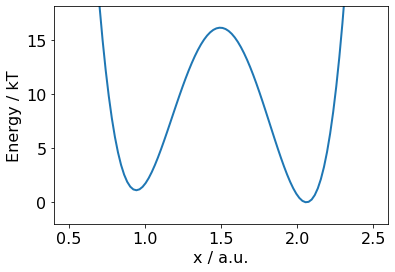

In [12]:
xx, xE = model.plot_dimer_energy()

In [13]:
W = np.exp(-xE)
-np.log(np.sum(W[xx < 1.5]) / np.sum(W[xx >= 1.5]))

1.1036920414270517

In [14]:
# hyperparameters
hyperparams = {'layer_types' : 'RRRRRRRR',
               'nl_layers' : 3,
               'nl_hidden' : 200,
               'nl_activation' : 'tanh',
               'zstd' : 1.0,
               'reg_Jxz' : 0.0,
               'temperature' : [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0],
               'weight_ML' : 0.1,
               'weight_W2' : 0.0,
               'weight_RC' : 10.0,
               }

Umbrella samplinig reference
-------

In [16]:
from deep_boltzmann.sampling.umbrella_sampling import UmbrellaSampling
from deep_boltzmann.sampling.metropolis import MetropolisGauss

In [17]:
## Either run Umbrella Sampling here....
#sampler = MetropolisGauss(model, model.init_positions(1.0), noise=0.02, stride=10)
#sampler.run(nsteps=10000)
#us = UmbrellaSampling(model, sampler, model.dimer_distance, sampler.traj[-1], 30, 250, 0.7, 2.3, forward_backward=True)
#us.run(nsteps=20000, verbose=True)

0.15 -60.78149494219376
0.15 -54.80906030006441
0.15 -66.82129157380976
0.25 -34.02408228190505
0.25 -36.378770183999876
0.25 -31.033689809728696
0.5 -14.286441470542922
0.5 -15.261248313620838
0.5 -13.63487889725406
1.0 -6.628717637498096
1.0 -7.124522164227016
1.0 -7.547679576558392
2.0 -3.3690130502955613
2.0 -3.298268077804168
2.0 -3.0709626368335443


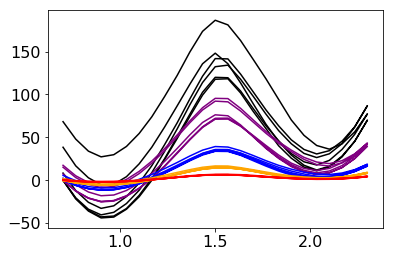

In [18]:
## ... or load saved Umbrella Sampling data.
npzfile = np.load('./particles/US_data.npz')
colors = ['black', 'purple', 'blue', 'orange', 'red']
x = npzfile['umbrella_positions']
temperatures_US = npzfile['temperatures']
dF_closed_open_US = []
for i, dF in enumerate(npzfile['umbrella_free_energies']):
    icolor = i // 3
    plt.plot(x, dF, color=colors[icolor])
    W = np.exp(-dF)
    dF_at_kT0 = -np.log(np.sum(W[x < 1.5]) / np.sum(W[x >= 1.5]))
    dF_closed_open_US.append(dF_at_kT0)
    print(temperatures_US[i], dF_at_kT0)    

In [19]:
# Estimate free energy profile and errors at kT=1 
umbrella_positions = npzfile['umbrella_positions']
# split in two halves because we ran forward and backward
umbrella_positions = umbrella_positions[:umbrella_positions.size//2]
umbrella_free_energies = [npzfile['umbrella_free_energies'][i][:umbrella_positions.size] for i in range(9, 12)] \
                       + [npzfile['umbrella_free_energies'][i][umbrella_positions.size:][::-1] for i in range(9, 12)] 
# align values
umbrella_free_energies = [F-F.mean() for F in umbrella_free_energies]

Boltzmann Generator
-------

In [15]:
batchsize_ML = 128
batchsize_KL = 1000
noise_intensity = 0.05

In [16]:
X0 = np.repeat(traj_closed_train[-1:], 1000, axis=0)
#X0 = np.vstack([traj_open_train[:1], traj_closed_train[:1]])

In [17]:
X0noise = X0 + noise_intensity * np.random.randn(X0.shape[0], X0.shape[1])
X0noise = X0noise.astype(np.float32)

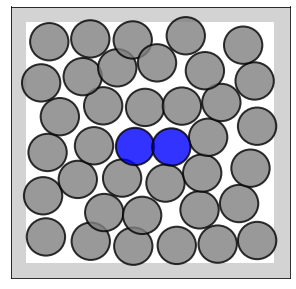

In [18]:
model.draw_config(X0noise[1], dimercolor='blue', alpha=0.8);
#plt.savefig(paper_dir + 'figs/particles/explore_initconf.pdf', bbox_inches='tight')

In [19]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh') # , whiten=X0noise

<RRRRRRRR>
< 76 0 0
R 38 38 0

R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0




In [20]:
loss_bg_trainML, loss_bg_valML = bg.train_ML(X0noise, xval=xval, epochs=200, lr=0.00025, batch_size=batchsize_ML, 
                                             std=1.0, verbose=1, return_test_energies=False)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 0/200 loss 317.5449 158.8376 
Epoch 1/200 loss 147.8968 94.8058 
Epoch 2/200 loss 81.7794 65.8784 
Epoch 3/200 loss 52.4690 52.2570 
Epoch 4/200 loss 38.7188 45.3677 
Epoch 5/200 loss 31.0619 42.3538 
Epoch 6/200 loss 25.7922 41.2586 
Epoch 7/200 loss 21.4260 40.9179 
Epoch 8/200 loss 17.3496 41.1269 
Epoch 9/200 loss 13.2652 42.3229 
Epoch 10/200 loss 8.9615 43.8094 
Epoch 11/200 loss 4.3970 48.5631 
Epoch 12/200 loss -0.4145 55.4124 
Epoch 13/200 loss -5.9006 64.8607 
Epoch 14/200 loss -11.8580 79.5249 
Epoch 15/200 loss -18.1519 97.9828 
Epoch 16/200 loss -25.0264 125.8163 
Epoch 17/200 loss -32.5667 163.9297 
Epoch 18/200 loss -40.1951 207.7020 
Epoch 19/200 loss -47.3341 222.2286 
Epoch 20/200 loss -52.9211 243.5012 
Epoch 21/200 loss -54.2253 208.6968 
Epoch 22/200 loss -55.3765 205.7849 
Epoch 23/200 loss -67.1924 219.4848 
Epoch 24/200 loss -64.8500 188.9837 
Epoch 25/200 loss

Epoch 191/200 loss -179.5551 275.8507 
Epoch 192/200 loss -178.5313 267.4731 
Epoch 193/200 loss -179.6392 266.0058 
Epoch 194/200 loss -179.0874 269.2004 
Epoch 195/200 loss -178.5516 273.7161 
Epoch 196/200 loss -179.1906 266.6980 
Epoch 197/200 loss -180.2023 265.1528 
Epoch 198/200 loss -178.6614 271.2531 
Epoch 199/200 loss -179.5829 270.5896 


(-150, 200)

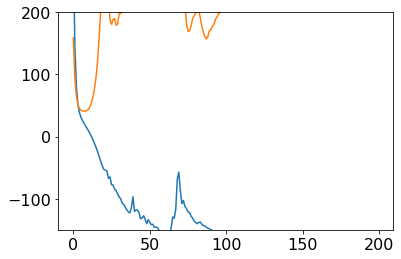

In [21]:
plt.plot(loss_bg_trainML)
plt.plot(loss_bg_valML)
plt.ylim(-150, 200)

(0, 3)

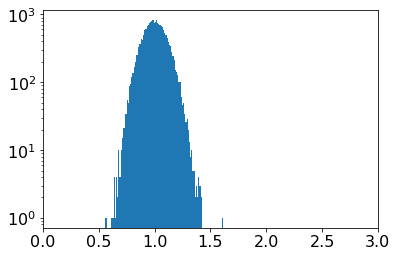

In [22]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

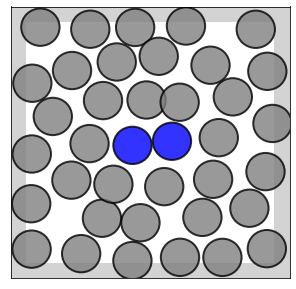

In [23]:
model.draw_config(sample_x[100], dimercolor='blue', alpha=0.8);

Adaptive sampling
-----

In [24]:
temperature=1.0

In [25]:
from deep_boltzmann.networks.training import ParticleFilter
from deep_boltzmann.sampling.permutation import HungarianMapper

In [32]:
mapper = HungarianMapper(model.init_positions(1.5), identical_particles=np.arange(2, model.nparticles))

In [33]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh') # , whiten=X0noise

<RRRRRRRR>
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0


In [34]:
loss_bg_trainML, loss_bg_valML = bg.train_ML(X0noise, xval=xval, epochs=200, lr=0.00025, batch_size=batchsize_ML, 
                                             std=1.0, verbose=0, return_test_energies=False)

In [35]:
particle_filter_ex = ParticleFilter(bg, X0noise, 100000, lr=0.0001, batch_size=batchsize_KL, 
                                    high_energy=10000, max_energy=1e10, std=1.0, 
                                    w_ML=1.0, w_KL=1.0, w_RC=1.0, 
                                    rc_func=model.dimer_distance_tf, rc_min=0.5, rc_max=2.5,
                                    weigh_ML=False, mapper=mapper)

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'index_layer_9/GatherV2:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'index_layer_12/GatherV2:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'index_layer_12/GatherV2:0' shape=(?, 76) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [36]:
Ds = [np.repeat(model.dimer_distance(X0noise), 100, axis=0)]

In [37]:
niter = 40
for i in range(niter):
    print('\nITER',(i+1),'/',niter)
    particle_filter_ex.train(epochs=50, stepsize=None, verbose=1)
    Ds.append(model.dimer_distance(particle_filter_ex.X))


ITER 1 / 40
Epoch 0/50 loss 673.3026 index_layer_9_loss -175.5162 index_layer_12_loss 768.2699 index_layer_12_loss 80.5489 p_acc 0.443 step 0.1
Epoch 1/50 loss 3702.9326 index_layer_9_loss -67.5261 index_layer_12_loss 3688.4121 index_layer_12_loss 82.0466 p_acc 0.374 step 0.1
Epoch 2/50 loss 824.8469 index_layer_9_loss -92.7929 index_layer_12_loss 839.0975 index_layer_12_loss 78.5424 p_acc 0.339 step 0.1
Epoch 3/50 loss 972.9394 index_layer_9_loss -28.2811 index_layer_12_loss 925.9525 index_layer_12_loss 75.2680 p_acc 0.256 step 0.1
Epoch 4/50 loss 1870.4940 index_layer_9_loss 43.2581 index_layer_12_loss 1754.3750 index_layer_12_loss 72.8608 p_acc 0.248 step 0.1
Epoch 5/50 loss 2067.5278 index_layer_9_loss 85.7912 index_layer_12_loss 1907.5341 index_layer_12_loss 74.2026 p_acc 0.205 step 0.1
Epoch 6/50 loss 1856.7053 index_layer_9_loss 100.2150 index_layer_12_loss 1681.6040 index_layer_12_loss 74.8864 p_acc 0.232 step 0.1
Epoch 7/50 loss 1672.6381 index_layer_9_loss 101.5191 index_lay

Epoch 11/50 loss 330.6891 index_layer_9_loss -147.8682 index_layer_12_loss 403.3034 index_layer_12_loss 75.2539 p_acc 0.363 step 0.12682417945625454
Epoch 12/50 loss 323.7270 index_layer_9_loss -148.2520 index_layer_12_loss 396.6011 index_layer_12_loss 75.3779 p_acc 0.395 step 0.12936066304537963
Epoch 13/50 loss 313.5671 index_layer_9_loss -149.5487 index_layer_12_loss 388.6303 index_layer_12_loss 74.4855 p_acc 0.366 step 0.13194787630628724
Epoch 14/50 loss 316.4033 index_layer_9_loss -150.0819 index_layer_12_loss 391.6850 index_layer_12_loss 74.8002 p_acc 0.349 step 0.134586833832413
Epoch 15/50 loss 316.6856 index_layer_9_loss -152.3036 index_layer_12_loss 394.7509 index_layer_12_loss 74.2383 p_acc 0.341 step 0.13727857050906125
Epoch 16/50 loss 313.9269 index_layer_9_loss -151.1495 index_layer_12_loss 390.7408 index_layer_12_loss 74.3356 p_acc 0.356 step 0.14002414191924248
Epoch 17/50 loss 318.1539 index_layer_9_loss -148.4742 index_layer_12_loss 391.5421 index_layer_12_loss 75.0

Epoch 17/50 loss 258.8581 index_layer_9_loss -158.1306 index_layer_12_loss 348.8921 index_layer_12_loss 68.0967 p_acc 0.111 step 0.38442505025455975
Epoch 18/50 loss 252.8843 index_layer_9_loss -159.3574 index_layer_12_loss 346.4156 index_layer_12_loss 65.8261 p_acc 0.092 step 0.39211355125965097
Epoch 19/50 loss 255.0489 index_layer_9_loss -156.4715 index_layer_12_loss 344.6528 index_layer_12_loss 66.8676 p_acc 0.122 step 0.399955822284844
Epoch 20/50 loss 246.9425 index_layer_9_loss -160.5508 index_layer_12_loss 344.6862 index_layer_12_loss 62.8071 p_acc 0.115 step 0.4079549387305409
Epoch 21/50 loss 249.7269 index_layer_9_loss -159.3950 index_layer_12_loss 344.0330 index_layer_12_loss 65.0890 p_acc 0.096 step 0.41611403750515175
Epoch 22/50 loss 251.6602 index_layer_9_loss -158.1542 index_layer_12_loss 344.6041 index_layer_12_loss 65.2104 p_acc 0.094 step 0.4244363182552548
Epoch 23/50 loss 245.6585 index_layer_9_loss -158.0670 index_layer_12_loss 339.4862 index_layer_12_loss 64.239

Epoch 23/50 loss 206.9424 index_layer_9_loss -164.2302 index_layer_12_loss 333.1268 index_layer_12_loss 38.0458 p_acc 0.114 step 0.4244363182552548
Epoch 24/50 loss 207.2848 index_layer_9_loss -163.6615 index_layer_12_loss 332.5662 index_layer_12_loss 38.3801 p_acc 0.108 step 0.4244363182552548
Epoch 25/50 loss 207.0916 index_layer_9_loss -164.1696 index_layer_12_loss 332.7172 index_layer_12_loss 38.5439 p_acc 0.103 step 0.4244363182552548
Epoch 26/50 loss 208.7042 index_layer_9_loss -164.0842 index_layer_12_loss 330.6860 index_layer_12_loss 42.1024 p_acc 0.127 step 0.4244363182552548
Epoch 27/50 loss 209.3115 index_layer_9_loss -163.6960 index_layer_12_loss 333.9018 index_layer_12_loss 39.1057 p_acc 0.121 step 0.4244363182552548
Epoch 28/50 loss 202.8661 index_layer_9_loss -164.5087 index_layer_12_loss 328.9143 index_layer_12_loss 38.4605 p_acc 0.11 step 0.4244363182552548
Epoch 29/50 loss 208.9182 index_layer_9_loss -164.7915 index_layer_12_loss 334.0444 index_layer_12_loss 39.6654 p

Epoch 29/50 loss 181.8675 index_layer_9_loss -167.7234 index_layer_12_loss 316.2894 index_layer_12_loss 33.3016 p_acc 0.144 step 0.4244363182552548
Epoch 30/50 loss 184.6916 index_layer_9_loss -167.6341 index_layer_12_loss 318.9385 index_layer_12_loss 33.3872 p_acc 0.13 step 0.4244363182552548
Epoch 31/50 loss 183.3193 index_layer_9_loss -167.7306 index_layer_12_loss 317.6925 index_layer_12_loss 33.3574 p_acc 0.158 step 0.4244363182552548
Epoch 32/50 loss 182.0145 index_layer_9_loss -167.7377 index_layer_12_loss 316.4158 index_layer_12_loss 33.3364 p_acc 0.13 step 0.4244363182552548
Epoch 33/50 loss 182.1769 index_layer_9_loss -167.5176 index_layer_12_loss 314.8584 index_layer_12_loss 34.8362 p_acc 0.139 step 0.4244363182552548
Epoch 34/50 loss 182.6833 index_layer_9_loss -168.4524 index_layer_12_loss 318.3630 index_layer_12_loss 32.7727 p_acc 0.144 step 0.4244363182552548
Epoch 35/50 loss 182.1946 index_layer_9_loss -167.7507 index_layer_12_loss 316.0916 index_layer_12_loss 33.8537 p_

Epoch 35/50 loss 171.6258 index_layer_9_loss -169.7936 index_layer_12_loss 306.7382 index_layer_12_loss 34.6812 p_acc 0.174 step 0.4244363182552548
Epoch 36/50 loss 170.0842 index_layer_9_loss -169.6089 index_layer_12_loss 306.1273 index_layer_12_loss 33.5659 p_acc 0.177 step 0.4244363182552548
Epoch 37/50 loss 168.7144 index_layer_9_loss -170.3493 index_layer_12_loss 304.4448 index_layer_12_loss 34.6189 p_acc 0.156 step 0.4244363182552548
Epoch 38/50 loss 167.1424 index_layer_9_loss -170.2577 index_layer_12_loss 303.3993 index_layer_12_loss 34.0007 p_acc 0.143 step 0.4244363182552548
Epoch 39/50 loss 167.5686 index_layer_9_loss -170.3953 index_layer_12_loss 304.5939 index_layer_12_loss 33.3701 p_acc 0.2 step 0.4244363182552548
Epoch 40/50 loss 170.2141 index_layer_9_loss -170.6290 index_layer_12_loss 307.6807 index_layer_12_loss 33.1624 p_acc 0.18 step 0.4244363182552548
Epoch 41/50 loss 166.8218 index_layer_9_loss -170.3709 index_layer_12_loss 303.6043 index_layer_12_loss 33.5884 p_a

Epoch 41/50 loss 165.6078 index_layer_9_loss -168.7273 index_layer_12_loss 300.7003 index_layer_12_loss 33.6348 p_acc 0.216 step 0.4244363182552548
Epoch 42/50 loss 164.1575 index_layer_9_loss -169.6440 index_layer_12_loss 300.1973 index_layer_12_loss 33.6042 p_acc 0.226 step 0.4244363182552548
Epoch 43/50 loss 164.2466 index_layer_9_loss -168.2431 index_layer_12_loss 298.3257 index_layer_12_loss 34.1640 p_acc 0.198 step 0.4244363182552548
Epoch 44/50 loss 163.4281 index_layer_9_loss -169.1879 index_layer_12_loss 298.9637 index_layer_12_loss 33.6524 p_acc 0.196 step 0.4244363182552548
Epoch 45/50 loss 163.8477 index_layer_9_loss -169.0472 index_layer_12_loss 298.3192 index_layer_12_loss 34.5757 p_acc 0.202 step 0.4244363182552548
Epoch 46/50 loss 162.5477 index_layer_9_loss -168.6598 index_layer_12_loss 297.8604 index_layer_12_loss 33.3472 p_acc 0.184 step 0.4244363182552548
Epoch 47/50 loss 164.4522 index_layer_9_loss -168.9639 index_layer_12_loss 299.1404 index_layer_12_loss 34.2757 

Epoch 47/50 loss 154.9123 index_layer_9_loss -171.2496 index_layer_12_loss 293.6363 index_layer_12_loss 32.5257 p_acc 0.154 step 0.5173855035962746
Epoch 48/50 loss 156.1186 index_layer_9_loss -171.0141 index_layer_12_loss 294.1319 index_layer_12_loss 33.0007 p_acc 0.147 step 0.5173855035962746
Epoch 49/50 loss 154.3664 index_layer_9_loss -171.4220 index_layer_12_loss 293.5928 index_layer_12_loss 32.1956 p_acc 0.147 step 0.5173855035962746

ITER 9 / 40
Epoch 0/50 loss 158.5769 index_layer_9_loss -171.3873 index_layer_12_loss 298.3016 index_layer_12_loss 31.6626 p_acc 0.141 step 0.5173855035962746
Epoch 1/50 loss 154.6636 index_layer_9_loss -170.7598 index_layer_12_loss 292.3316 index_layer_12_loss 33.0918 p_acc 0.153 step 0.5173855035962746
Epoch 2/50 loss 153.9267 index_layer_9_loss -171.2377 index_layer_12_loss 292.3998 index_layer_12_loss 32.7646 p_acc 0.153 step 0.5173855035962746
Epoch 3/50 loss 153.8404 index_layer_9_loss -172.0903 index_layer_12_loss 293.0684 index_layer_12_loss

Epoch 3/50 loss 150.2559 index_layer_9_loss -171.9538 index_layer_12_loss 289.8236 index_layer_12_loss 32.3860 p_acc 0.176 step 0.5173855035962746
Epoch 4/50 loss 150.6220 index_layer_9_loss -171.7267 index_layer_12_loss 290.3343 index_layer_12_loss 32.0145 p_acc 0.183 step 0.5173855035962746
Epoch 5/50 loss 149.9990 index_layer_9_loss -171.9568 index_layer_12_loss 289.6812 index_layer_12_loss 32.2746 p_acc 0.178 step 0.5173855035962746
Epoch 6/50 loss 150.8039 index_layer_9_loss -171.8843 index_layer_12_loss 290.9279 index_layer_12_loss 31.7603 p_acc 0.172 step 0.5173855035962746
Epoch 7/50 loss 150.4890 index_layer_9_loss -172.3206 index_layer_12_loss 290.9893 index_layer_12_loss 31.8203 p_acc 0.163 step 0.5173855035962746
Epoch 8/50 loss 149.8534 index_layer_9_loss -172.1277 index_layer_12_loss 289.9577 index_layer_12_loss 32.0234 p_acc 0.174 step 0.5173855035962746
Epoch 9/50 loss 149.2899 index_layer_9_loss -172.3876 index_layer_12_loss 287.9651 index_layer_12_loss 33.7124 p_acc 0

Epoch 9/50 loss 149.6329 index_layer_9_loss -170.0767 index_layer_12_loss 287.6851 index_layer_12_loss 32.0245 p_acc 0.162 step 0.5173855035962746
Epoch 10/50 loss 149.3549 index_layer_9_loss -170.7501 index_layer_12_loss 287.8267 index_layer_12_loss 32.2784 p_acc 0.195 step 0.5173855035962746
Epoch 11/50 loss 149.4692 index_layer_9_loss -169.7310 index_layer_12_loss 286.3869 index_layer_12_loss 32.8132 p_acc 0.197 step 0.5173855035962746
Epoch 12/50 loss 152.4787 index_layer_9_loss -169.8677 index_layer_12_loss 287.9973 index_layer_12_loss 34.3491 p_acc 0.19 step 0.5173855035962746
Epoch 13/50 loss 149.9989 index_layer_9_loss -169.6250 index_layer_12_loss 286.0839 index_layer_12_loss 33.5401 p_acc 0.164 step 0.5173855035962746
Epoch 14/50 loss 147.9390 index_layer_9_loss -170.2848 index_layer_12_loss 285.7198 index_layer_12_loss 32.5039 p_acc 0.174 step 0.5173855035962746
Epoch 15/50 loss 149.9953 index_layer_9_loss -169.2988 index_layer_12_loss 286.2028 index_layer_12_loss 33.0913 p_

Epoch 15/50 loss 143.6522 index_layer_9_loss -171.9442 index_layer_12_loss 282.8195 index_layer_12_loss 32.7769 p_acc 0.196 step 0.5173855035962746
Epoch 16/50 loss 144.8680 index_layer_9_loss -172.0632 index_layer_12_loss 284.9981 index_layer_12_loss 31.9331 p_acc 0.206 step 0.5173855035962746
Epoch 17/50 loss 144.1528 index_layer_9_loss -171.6035 index_layer_12_loss 283.8423 index_layer_12_loss 31.9140 p_acc 0.186 step 0.5173855035962746
Epoch 18/50 loss 143.9620 index_layer_9_loss -172.2801 index_layer_12_loss 284.4064 index_layer_12_loss 31.8357 p_acc 0.217 step 0.5173855035962746
Epoch 19/50 loss 142.9218 index_layer_9_loss -172.3619 index_layer_12_loss 284.0881 index_layer_12_loss 31.1956 p_acc 0.216 step 0.5173855035962746
Epoch 20/50 loss 144.4049 index_layer_9_loss -171.8548 index_layer_12_loss 285.2333 index_layer_12_loss 31.0263 p_acc 0.21 step 0.5173855035962746
Epoch 21/50 loss 143.5110 index_layer_9_loss -172.1310 index_layer_12_loss 283.7837 index_layer_12_loss 31.8583 p

Epoch 21/50 loss 142.0370 index_layer_9_loss -172.4961 index_layer_12_loss 281.9162 index_layer_12_loss 32.6170 p_acc 0.197 step 0.5490536355003953
Epoch 22/50 loss 140.9077 index_layer_9_loss -172.2375 index_layer_12_loss 281.1371 index_layer_12_loss 32.0081 p_acc 0.169 step 0.5490536355003953
Epoch 23/50 loss 141.1472 index_layer_9_loss -172.7490 index_layer_12_loss 281.2053 index_layer_12_loss 32.6909 p_acc 0.191 step 0.5490536355003953
Epoch 24/50 loss 141.7713 index_layer_9_loss -172.4228 index_layer_12_loss 281.7049 index_layer_12_loss 32.4893 p_acc 0.203 step 0.5490536355003953
Epoch 25/50 loss 150.8977 index_layer_9_loss -172.8896 index_layer_12_loss 292.3362 index_layer_12_loss 31.4511 p_acc 0.203 step 0.5490536355003953
Epoch 26/50 loss 143.5073 index_layer_9_loss -172.3484 index_layer_12_loss 284.4726 index_layer_12_loss 31.3830 p_acc 0.193 step 0.5490536355003953
Epoch 27/50 loss 140.3647 index_layer_9_loss -172.6773 index_layer_12_loss 281.2005 index_layer_12_loss 31.8416 

Epoch 27/50 loss 145.5385 index_layer_9_loss -169.5688 index_layer_12_loss 283.3747 index_layer_12_loss 31.7326 p_acc 0.209 step 0.5490536355003953
Epoch 28/50 loss 147.1258 index_layer_9_loss -169.0427 index_layer_12_loss 284.5221 index_layer_12_loss 31.6464 p_acc 0.186 step 0.5490536355003953
Epoch 29/50 loss 144.8838 index_layer_9_loss -169.2469 index_layer_12_loss 282.1264 index_layer_12_loss 32.0043 p_acc 0.174 step 0.5490536355003953
Epoch 30/50 loss 145.1337 index_layer_9_loss -169.3871 index_layer_12_loss 283.2111 index_layer_12_loss 31.3098 p_acc 0.177 step 0.5490536355003953
Epoch 31/50 loss 144.9607 index_layer_9_loss -169.1141 index_layer_12_loss 282.9883 index_layer_12_loss 31.0865 p_acc 0.189 step 0.5490536355003953
Epoch 32/50 loss 143.4889 index_layer_9_loss -169.2951 index_layer_12_loss 280.1009 index_layer_12_loss 32.6831 p_acc 0.178 step 0.5490536355003953
Epoch 33/50 loss 145.0734 index_layer_9_loss -168.8130 index_layer_12_loss 282.3224 index_layer_12_loss 31.5640 

Epoch 33/50 loss 139.0383 index_layer_9_loss -171.2788 index_layer_12_loss 279.4139 index_layer_12_loss 30.9031 p_acc 0.183 step 0.5490536355003953
Epoch 34/50 loss 138.7822 index_layer_9_loss -171.3266 index_layer_12_loss 279.0060 index_layer_12_loss 31.1028 p_acc 0.2 step 0.5490536355003953
Epoch 35/50 loss 138.5734 index_layer_9_loss -171.1098 index_layer_12_loss 277.8997 index_layer_12_loss 31.7835 p_acc 0.195 step 0.5490536355003953
Epoch 36/50 loss 138.5478 index_layer_9_loss -171.4444 index_layer_12_loss 278.3110 index_layer_12_loss 31.6812 p_acc 0.2 step 0.5490536355003953
Epoch 37/50 loss 139.3971 index_layer_9_loss -171.2968 index_layer_12_loss 280.1214 index_layer_12_loss 30.5725 p_acc 0.161 step 0.5490536355003953
Epoch 38/50 loss 139.9976 index_layer_9_loss -170.7691 index_layer_12_loss 280.1374 index_layer_12_loss 30.6293 p_acc 0.177 step 0.5490536355003953
Epoch 39/50 loss 138.8294 index_layer_9_loss -171.6390 index_layer_12_loss 280.0331 index_layer_12_loss 30.4353 p_ac

Epoch 39/50 loss 137.7999 index_layer_9_loss -171.5108 index_layer_12_loss 277.7355 index_layer_12_loss 31.5752 p_acc 0.173 step 0.5490536355003953
Epoch 40/50 loss 150.4984 index_layer_9_loss -170.6878 index_layer_12_loss 289.8412 index_layer_12_loss 31.3450 p_acc 0.185 step 0.5490536355003953
Epoch 41/50 loss 139.4878 index_layer_9_loss -171.2810 index_layer_12_loss 279.6203 index_layer_12_loss 31.1484 p_acc 0.177 step 0.5490536355003953
Epoch 42/50 loss 137.9660 index_layer_9_loss -170.8506 index_layer_12_loss 278.4863 index_layer_12_loss 30.3303 p_acc 0.186 step 0.5490536355003953
Epoch 43/50 loss 138.9919 index_layer_9_loss -171.3424 index_layer_12_loss 279.9276 index_layer_12_loss 30.4067 p_acc 0.212 step 0.5490536355003953
Epoch 44/50 loss 138.2586 index_layer_9_loss -171.2127 index_layer_12_loss 278.9900 index_layer_12_loss 30.4814 p_acc 0.202 step 0.5490536355003953
Epoch 45/50 loss 137.4652 index_layer_9_loss -171.5869 index_layer_12_loss 278.8394 index_layer_12_loss 30.2127 

Epoch 45/50 loss 136.5303 index_layer_9_loss -170.8264 index_layer_12_loss 277.2088 index_layer_12_loss 30.1479 p_acc 0.193 step 0.5490536355003953
Epoch 46/50 loss 137.0002 index_layer_9_loss -171.5918 index_layer_12_loss 277.8034 index_layer_12_loss 30.7886 p_acc 0.172 step 0.5490536355003953
Epoch 47/50 loss 135.3949 index_layer_9_loss -171.3040 index_layer_12_loss 276.3351 index_layer_12_loss 30.3638 p_acc 0.186 step 0.5490536355003953
Epoch 48/50 loss 136.1611 index_layer_9_loss -171.3179 index_layer_12_loss 277.2546 index_layer_12_loss 30.2244 p_acc 0.177 step 0.5490536355003953
Epoch 49/50 loss 136.7191 index_layer_9_loss -171.2803 index_layer_12_loss 277.2403 index_layer_12_loss 30.7590 p_acc 0.183 step 0.5490536355003953

ITER 18 / 40
Epoch 0/50 loss 136.1289 index_layer_9_loss -171.3583 index_layer_12_loss 277.4686 index_layer_12_loss 30.0186 p_acc 0.2 step 0.5490536355003953
Epoch 1/50 loss 136.7462 index_layer_9_loss -171.3230 index_layer_12_loss 277.7812 index_layer_12_los

Epoch 1/50 loss 136.2056 index_layer_9_loss -170.9566 index_layer_12_loss 277.3760 index_layer_12_loss 29.7861 p_acc 0.203 step 0.5490536355003953
Epoch 2/50 loss 136.0358 index_layer_9_loss -170.6234 index_layer_12_loss 276.0296 index_layer_12_loss 30.6297 p_acc 0.18 step 0.5490536355003953
Epoch 3/50 loss 135.6231 index_layer_9_loss -171.1322 index_layer_12_loss 276.2126 index_layer_12_loss 30.5427 p_acc 0.212 step 0.5490536355003953
Epoch 4/50 loss 134.7151 index_layer_9_loss -171.3894 index_layer_12_loss 276.0530 index_layer_12_loss 30.0515 p_acc 0.197 step 0.5490536355003953
Epoch 5/50 loss 136.0102 index_layer_9_loss -170.8094 index_layer_12_loss 277.0828 index_layer_12_loss 29.7368 p_acc 0.181 step 0.5490536355003953
Epoch 6/50 loss 134.7254 index_layer_9_loss -171.3990 index_layer_12_loss 276.6431 index_layer_12_loss 29.4813 p_acc 0.187 step 0.5490536355003953
Epoch 7/50 loss 135.3978 index_layer_9_loss -171.0021 index_layer_12_loss 276.1195 index_layer_12_loss 30.2803 p_acc 0.

Epoch 7/50 loss 134.7019 index_layer_9_loss -170.3681 index_layer_12_loss 275.6146 index_layer_12_loss 29.4553 p_acc 0.173 step 0.5490536355003953
Epoch 8/50 loss 134.6977 index_layer_9_loss -170.2879 index_layer_12_loss 275.8345 index_layer_12_loss 29.1511 p_acc 0.187 step 0.5490536355003953
Epoch 9/50 loss 134.6911 index_layer_9_loss -171.1946 index_layer_12_loss 276.3890 index_layer_12_loss 29.4966 p_acc 0.198 step 0.5490536355003953
Epoch 10/50 loss 134.9792 index_layer_9_loss -170.3289 index_layer_12_loss 275.1972 index_layer_12_loss 30.1108 p_acc 0.173 step 0.5490536355003953
Epoch 11/50 loss 134.0459 index_layer_9_loss -170.4115 index_layer_12_loss 274.9745 index_layer_12_loss 29.4829 p_acc 0.178 step 0.5490536355003953
Epoch 12/50 loss 135.5445 index_layer_9_loss -170.2281 index_layer_12_loss 275.3029 index_layer_12_loss 30.4697 p_acc 0.198 step 0.5490536355003953
Epoch 13/50 loss 133.4405 index_layer_9_loss -170.9695 index_layer_12_loss 274.4389 index_layer_12_loss 29.9710 p_a

Epoch 13/50 loss 137.3225 index_layer_9_loss -169.6666 index_layer_12_loss 277.6650 index_layer_12_loss 29.3242 p_acc 0.145 step 0.5490536355003953
Epoch 14/50 loss 138.6000 index_layer_9_loss -170.1960 index_layer_12_loss 278.7745 index_layer_12_loss 30.0215 p_acc 0.173 step 0.5490536355003953
Epoch 15/50 loss 135.0720 index_layer_9_loss -170.2252 index_layer_12_loss 274.7796 index_layer_12_loss 30.5176 p_acc 0.176 step 0.5490536355003953
Epoch 16/50 loss 136.5491 index_layer_9_loss -170.1983 index_layer_12_loss 276.5085 index_layer_12_loss 30.2388 p_acc 0.168 step 0.5490536355003953
Epoch 17/50 loss 133.8911 index_layer_9_loss -170.3610 index_layer_12_loss 274.2860 index_layer_12_loss 29.9661 p_acc 0.167 step 0.5490536355003953
Epoch 18/50 loss 137.1663 index_layer_9_loss -170.2212 index_layer_12_loss 277.6944 index_layer_12_loss 29.6932 p_acc 0.186 step 0.5490536355003953
Epoch 19/50 loss 134.2097 index_layer_9_loss -170.5409 index_layer_12_loss 275.1843 index_layer_12_loss 29.5664 

Epoch 19/50 loss 136.3416 index_layer_9_loss -168.7557 index_layer_12_loss 275.3010 index_layer_12_loss 29.7964 p_acc 0.162 step 0.5490536355003953
Epoch 20/50 loss 135.3126 index_layer_9_loss -169.4155 index_layer_12_loss 273.7279 index_layer_12_loss 31.0002 p_acc 0.151 step 0.5490536355003953
Epoch 21/50 loss 136.4794 index_layer_9_loss -168.5656 index_layer_12_loss 274.7260 index_layer_12_loss 30.3191 p_acc 0.163 step 0.5490536355003953
Epoch 22/50 loss 136.2740 index_layer_9_loss -168.8392 index_layer_12_loss 274.7234 index_layer_12_loss 30.3898 p_acc 0.166 step 0.5490536355003953
Epoch 23/50 loss 136.0939 index_layer_9_loss -168.7058 index_layer_12_loss 275.1078 index_layer_12_loss 29.6919 p_acc 0.157 step 0.5490536355003953
Epoch 24/50 loss 135.1260 index_layer_9_loss -169.0646 index_layer_12_loss 274.4572 index_layer_12_loss 29.7334 p_acc 0.154 step 0.5490536355003953
Epoch 25/50 loss 135.2874 index_layer_9_loss -169.0732 index_layer_12_loss 274.1985 index_layer_12_loss 30.1622 

Epoch 25/50 loss 133.2273 index_layer_9_loss -169.6466 index_layer_12_loss 273.5517 index_layer_12_loss 29.3222 p_acc 0.176 step 0.5490536355003953
Epoch 26/50 loss 133.7195 index_layer_9_loss -169.7972 index_layer_12_loss 273.8420 index_layer_12_loss 29.6747 p_acc 0.152 step 0.5490536355003953
Epoch 27/50 loss 133.2584 index_layer_9_loss -170.1603 index_layer_12_loss 273.3398 index_layer_12_loss 30.0789 p_acc 0.145 step 0.5490536355003953
Epoch 28/50 loss 135.2665 index_layer_9_loss -169.3579 index_layer_12_loss 275.3794 index_layer_12_loss 29.2449 p_acc 0.154 step 0.5490536355003953
Epoch 29/50 loss 133.9281 index_layer_9_loss -169.3760 index_layer_12_loss 274.1717 index_layer_12_loss 29.1323 p_acc 0.147 step 0.5490536355003953
Epoch 30/50 loss 133.4955 index_layer_9_loss -170.1743 index_layer_12_loss 273.7921 index_layer_12_loss 29.8777 p_acc 0.174 step 0.5490536355003953
Epoch 31/50 loss 133.6571 index_layer_9_loss -169.6496 index_layer_12_loss 273.7242 index_layer_12_loss 29.5825 

Epoch 31/50 loss 132.9010 index_layer_9_loss -169.9229 index_layer_12_loss 273.3672 index_layer_12_loss 29.4567 p_acc 0.163 step 0.5490536355003953
Epoch 32/50 loss 134.0775 index_layer_9_loss -168.3852 index_layer_12_loss 273.0601 index_layer_12_loss 29.4026 p_acc 0.142 step 0.5490536355003953
Epoch 33/50 loss 133.1752 index_layer_9_loss -169.6602 index_layer_12_loss 273.5875 index_layer_12_loss 29.2479 p_acc 0.145 step 0.5490536355003953
Epoch 34/50 loss 132.7646 index_layer_9_loss -169.3382 index_layer_12_loss 272.6056 index_layer_12_loss 29.4971 p_acc 0.139 step 0.5490536355003953
Epoch 35/50 loss 134.1552 index_layer_9_loss -169.1258 index_layer_12_loss 273.7016 index_layer_12_loss 29.5794 p_acc 0.139 step 0.5490536355003953
Epoch 36/50 loss 133.3158 index_layer_9_loss -169.4568 index_layer_12_loss 273.2063 index_layer_12_loss 29.5663 p_acc 0.163 step 0.5490536355003953
Epoch 37/50 loss 133.2262 index_layer_9_loss -169.5161 index_layer_12_loss 272.6755 index_layer_12_loss 30.0667 

Epoch 37/50 loss 133.5184 index_layer_9_loss -168.7509 index_layer_12_loss 272.6756 index_layer_12_loss 29.5938 p_acc 0.145 step 0.5490536355003953
Epoch 38/50 loss 133.9204 index_layer_9_loss -168.9281 index_layer_12_loss 273.6092 index_layer_12_loss 29.2393 p_acc 0.167 step 0.5490536355003953
Epoch 39/50 loss 132.9033 index_layer_9_loss -169.2590 index_layer_12_loss 272.7455 index_layer_12_loss 29.4167 p_acc 0.157 step 0.5490536355003953
Epoch 40/50 loss 133.3522 index_layer_9_loss -168.7667 index_layer_12_loss 272.4670 index_layer_12_loss 29.6519 p_acc 0.153 step 0.5490536355003953
Epoch 41/50 loss 133.6190 index_layer_9_loss -169.2286 index_layer_12_loss 273.3824 index_layer_12_loss 29.4651 p_acc 0.155 step 0.5490536355003953
Epoch 42/50 loss 132.7733 index_layer_9_loss -169.2329 index_layer_12_loss 272.6290 index_layer_12_loss 29.3772 p_acc 0.138 step 0.5490536355003953
Epoch 43/50 loss 133.2596 index_layer_9_loss -168.9375 index_layer_12_loss 272.8189 index_layer_12_loss 29.3782 

Epoch 43/50 loss 133.6321 index_layer_9_loss -168.5737 index_layer_12_loss 273.0990 index_layer_12_loss 29.1069 p_acc 0.149 step 0.5490536355003953
Epoch 44/50 loss 132.2025 index_layer_9_loss -168.9600 index_layer_12_loss 271.7058 index_layer_12_loss 29.4567 p_acc 0.142 step 0.5490536355003953
Epoch 45/50 loss 132.2296 index_layer_9_loss -168.6777 index_layer_12_loss 270.9598 index_layer_12_loss 29.9475 p_acc 0.157 step 0.5490536355003953
Epoch 46/50 loss 132.3241 index_layer_9_loss -169.0380 index_layer_12_loss 271.8021 index_layer_12_loss 29.5601 p_acc 0.149 step 0.5490536355003953
Epoch 47/50 loss 132.2254 index_layer_9_loss -168.5998 index_layer_12_loss 271.7422 index_layer_12_loss 29.0830 p_acc 0.152 step 0.5490536355003953
Epoch 48/50 loss 131.9957 index_layer_9_loss -168.8153 index_layer_12_loss 271.3876 index_layer_12_loss 29.4233 p_acc 0.14 step 0.5490536355003953
Epoch 49/50 loss 139.3390 index_layer_9_loss -168.7390 index_layer_12_loss 278.4947 index_layer_12_loss 29.5833 p

Epoch 49/50 loss 133.5195 index_layer_9_loss -167.8063 index_layer_12_loss 271.6042 index_layer_12_loss 29.7216 p_acc 0.123 step 0.5490536355003953

ITER 28 / 40
Epoch 0/50 loss 133.1236 index_layer_9_loss -168.6481 index_layer_12_loss 272.0796 index_layer_12_loss 29.6922 p_acc 0.115 step 0.5490536355003953
Epoch 1/50 loss 132.8959 index_layer_9_loss -167.9916 index_layer_12_loss 271.3943 index_layer_12_loss 29.4932 p_acc 0.12 step 0.5490536355003953
Epoch 2/50 loss 132.5248 index_layer_9_loss -167.8317 index_layer_12_loss 270.9935 index_layer_12_loss 29.3630 p_acc 0.136 step 0.5490536355003953
Epoch 3/50 loss 133.7001 index_layer_9_loss -167.5032 index_layer_12_loss 272.0076 index_layer_12_loss 29.1956 p_acc 0.13 step 0.5490536355003953
Epoch 4/50 loss 133.3963 index_layer_9_loss -168.0385 index_layer_12_loss 272.0820 index_layer_12_loss 29.3528 p_acc 0.141 step 0.5490536355003953
Epoch 5/50 loss 133.0681 index_layer_9_loss -168.2464 index_layer_12_loss 272.3837 index_layer_12_loss 28

Epoch 5/50 loss 132.0485 index_layer_9_loss -167.8348 index_layer_12_loss 270.9142 index_layer_12_loss 28.9691 p_acc 0.122 step 0.5490536355003953
Epoch 6/50 loss 132.8989 index_layer_9_loss -167.5108 index_layer_12_loss 271.1583 index_layer_12_loss 29.2515 p_acc 0.123 step 0.5490536355003953
Epoch 7/50 loss 132.4008 index_layer_9_loss -167.8273 index_layer_12_loss 270.7529 index_layer_12_loss 29.4752 p_acc 0.144 step 0.5490536355003953
Epoch 8/50 loss 133.1694 index_layer_9_loss -167.7394 index_layer_12_loss 271.6611 index_layer_12_loss 29.2478 p_acc 0.12 step 0.5490536355003953
Epoch 9/50 loss 132.2885 index_layer_9_loss -168.0594 index_layer_12_loss 270.6034 index_layer_12_loss 29.7446 p_acc 0.125 step 0.5490536355003953
Epoch 10/50 loss 132.5282 index_layer_9_loss -168.1821 index_layer_12_loss 271.5927 index_layer_12_loss 29.1177 p_acc 0.122 step 0.5490536355003953
Epoch 11/50 loss 132.1312 index_layer_9_loss -167.9487 index_layer_12_loss 270.4981 index_layer_12_loss 29.5818 p_acc 

Epoch 11/50 loss 132.0736 index_layer_9_loss -167.7819 index_layer_12_loss 270.2454 index_layer_12_loss 29.6101 p_acc 0.134 step 0.5490536355003953
Epoch 12/50 loss 132.7710 index_layer_9_loss -167.3877 index_layer_12_loss 270.8864 index_layer_12_loss 29.2723 p_acc 0.12 step 0.5490536355003953
Epoch 13/50 loss 132.5165 index_layer_9_loss -167.3837 index_layer_12_loss 270.8287 index_layer_12_loss 29.0715 p_acc 0.131 step 0.5490536355003953
Epoch 14/50 loss 131.8583 index_layer_9_loss -167.7531 index_layer_12_loss 270.0821 index_layer_12_loss 29.5293 p_acc 0.105 step 0.5490536355003953
Epoch 15/50 loss 131.9573 index_layer_9_loss -167.9663 index_layer_12_loss 270.6367 index_layer_12_loss 29.2869 p_acc 0.159 step 0.5490536355003953
Epoch 16/50 loss 132.1123 index_layer_9_loss -167.3690 index_layer_12_loss 269.9068 index_layer_12_loss 29.5745 p_acc 0.144 step 0.5490536355003953
Epoch 17/50 loss 131.0521 index_layer_9_loss -168.4490 index_layer_12_loss 270.3959 index_layer_12_loss 29.1052 p

Epoch 17/50 loss 131.5894 index_layer_9_loss -167.6819 index_layer_12_loss 269.8241 index_layer_12_loss 29.4472 p_acc 0.128 step 0.5490536355003953
Epoch 18/50 loss 131.6541 index_layer_9_loss -167.4468 index_layer_12_loss 269.7491 index_layer_12_loss 29.3519 p_acc 0.114 step 0.5490536355003953
Epoch 19/50 loss 131.6079 index_layer_9_loss -167.9350 index_layer_12_loss 270.0475 index_layer_12_loss 29.4954 p_acc 0.129 step 0.5490536355003953
Epoch 20/50 loss 131.7651 index_layer_9_loss -167.3736 index_layer_12_loss 269.7007 index_layer_12_loss 29.4380 p_acc 0.109 step 0.5490536355003953
Epoch 21/50 loss 131.5940 index_layer_9_loss -167.6987 index_layer_12_loss 269.8894 index_layer_12_loss 29.4033 p_acc 0.121 step 0.5490536355003953
Epoch 22/50 loss 131.8845 index_layer_9_loss -167.3908 index_layer_12_loss 269.9651 index_layer_12_loss 29.3103 p_acc 0.123 step 0.5490536355003953
Epoch 23/50 loss 131.3037 index_layer_9_loss -168.0533 index_layer_12_loss 269.9436 index_layer_12_loss 29.4134 

Epoch 23/50 loss 130.7380 index_layer_9_loss -167.7029 index_layer_12_loss 269.0162 index_layer_12_loss 29.4247 p_acc 0.121 step 0.5490536355003953
Epoch 24/50 loss 130.4571 index_layer_9_loss -168.0605 index_layer_12_loss 269.1629 index_layer_12_loss 29.3547 p_acc 0.132 step 0.5490536355003953
Epoch 25/50 loss 131.4907 index_layer_9_loss -167.7239 index_layer_12_loss 269.6443 index_layer_12_loss 29.5703 p_acc 0.134 step 0.5490536355003953
Epoch 26/50 loss 131.4352 index_layer_9_loss -167.1597 index_layer_12_loss 269.3430 index_layer_12_loss 29.2519 p_acc 0.115 step 0.5490536355003953
Epoch 27/50 loss 131.2492 index_layer_9_loss -168.1129 index_layer_12_loss 270.0126 index_layer_12_loss 29.3495 p_acc 0.132 step 0.5490536355003953
Epoch 28/50 loss 132.0902 index_layer_9_loss -167.3603 index_layer_12_loss 270.2530 index_layer_12_loss 29.1975 p_acc 0.128 step 0.5490536355003953
Epoch 29/50 loss 131.1039 index_layer_9_loss -167.8158 index_layer_12_loss 269.4023 index_layer_12_loss 29.5175 

Epoch 29/50 loss 132.0236 index_layer_9_loss -166.6727 index_layer_12_loss 269.2368 index_layer_12_loss 29.4595 p_acc 0.105 step 0.5490536355003953
Epoch 30/50 loss 130.5477 index_layer_9_loss -166.9718 index_layer_12_loss 268.3683 index_layer_12_loss 29.1512 p_acc 0.106 step 0.5490536355003953
Epoch 31/50 loss 131.1061 index_layer_9_loss -167.3740 index_layer_12_loss 269.5522 index_layer_12_loss 28.9279 p_acc 0.126 step 0.5490536355003953
Epoch 32/50 loss 131.4225 index_layer_9_loss -166.7609 index_layer_12_loss 269.0337 index_layer_12_loss 29.1497 p_acc 0.125 step 0.5490536355003953
Epoch 33/50 loss 131.7301 index_layer_9_loss -167.0173 index_layer_12_loss 269.2304 index_layer_12_loss 29.5170 p_acc 0.113 step 0.5490536355003953
Epoch 34/50 loss 130.5467 index_layer_9_loss -167.0493 index_layer_12_loss 268.4430 index_layer_12_loss 29.1530 p_acc 0.121 step 0.5490536355003953
Epoch 35/50 loss 130.7643 index_layer_9_loss -167.0082 index_layer_12_loss 268.4183 index_layer_12_loss 29.3542 

Epoch 35/50 loss 130.7463 index_layer_9_loss -167.1516 index_layer_12_loss 268.4796 index_layer_12_loss 29.4182 p_acc 0.108 step 0.5490536355003953
Epoch 36/50 loss 132.1212 index_layer_9_loss -166.3426 index_layer_12_loss 269.2536 index_layer_12_loss 29.2101 p_acc 0.103 step 0.5490536355003953
Epoch 37/50 loss 130.9548 index_layer_9_loss -167.2671 index_layer_12_loss 269.1348 index_layer_12_loss 29.0871 p_acc 0.096 step 0.5490536355003953
Epoch 38/50 loss 131.5035 index_layer_9_loss -166.6463 index_layer_12_loss 268.8228 index_layer_12_loss 29.3270 p_acc 0.117 step 0.5490536355003953
Epoch 39/50 loss 130.6938 index_layer_9_loss -167.0940 index_layer_12_loss 268.1901 index_layer_12_loss 29.5977 p_acc 0.114 step 0.5490536355003953
Epoch 40/50 loss 131.4608 index_layer_9_loss -166.7100 index_layer_12_loss 268.5426 index_layer_12_loss 29.6282 p_acc 0.108 step 0.5490536355003953
Epoch 41/50 loss 131.4797 index_layer_9_loss -166.5833 index_layer_12_loss 269.0967 index_layer_12_loss 28.9662 

Epoch 41/50 loss 130.9962 index_layer_9_loss -166.5786 index_layer_12_loss 268.5743 index_layer_12_loss 29.0004 p_acc 0.115 step 0.5490536355003953
Epoch 42/50 loss 130.9744 index_layer_9_loss -166.9142 index_layer_12_loss 268.3698 index_layer_12_loss 29.5189 p_acc 0.114 step 0.5490536355003953
Epoch 43/50 loss 131.1210 index_layer_9_loss -166.5831 index_layer_12_loss 268.2429 index_layer_12_loss 29.4612 p_acc 0.111 step 0.5490536355003953
Epoch 44/50 loss 130.6222 index_layer_9_loss -166.8036 index_layer_12_loss 268.0751 index_layer_12_loss 29.3506 p_acc 0.11 step 0.5490536355003953
Epoch 45/50 loss 131.0737 index_layer_9_loss -166.6846 index_layer_12_loss 268.4865 index_layer_12_loss 29.2717 p_acc 0.11 step 0.5490536355003953
Epoch 46/50 loss 132.1407 index_layer_9_loss -166.6929 index_layer_12_loss 269.5904 index_layer_12_loss 29.2432 p_acc 0.099 step 0.5490536355003953
Epoch 47/50 loss 132.0863 index_layer_9_loss -166.2337 index_layer_12_loss 268.8638 index_layer_12_loss 29.4563 p_

Epoch 47/50 loss 130.1906 index_layer_9_loss -166.9346 index_layer_12_loss 267.4411 index_layer_12_loss 29.6841 p_acc 0.098 step 0.5490536355003953
Epoch 48/50 loss 130.7114 index_layer_9_loss -166.4581 index_layer_12_loss 268.1797 index_layer_12_loss 28.9898 p_acc 0.11 step 0.5490536355003953
Epoch 49/50 loss 130.7487 index_layer_9_loss -166.0015 index_layer_12_loss 267.5124 index_layer_12_loss 29.2378 p_acc 0.111 step 0.5490536355003953

ITER 37 / 40
Epoch 0/50 loss 130.9762 index_layer_9_loss -166.2682 index_layer_12_loss 268.0342 index_layer_12_loss 29.2102 p_acc 0.121 step 0.5490536355003953
Epoch 1/50 loss 130.4646 index_layer_9_loss -166.2510 index_layer_12_loss 267.6096 index_layer_12_loss 29.1060 p_acc 0.112 step 0.5490536355003953
Epoch 2/50 loss 130.5458 index_layer_9_loss -166.4312 index_layer_12_loss 267.6433 index_layer_12_loss 29.3337 p_acc 0.12 step 0.5490536355003953
Epoch 3/50 loss 131.0707 index_layer_9_loss -166.0776 index_layer_12_loss 268.2302 index_layer_12_loss 

Epoch 3/50 loss 130.7180 index_layer_9_loss -166.5290 index_layer_12_loss 267.7956 index_layer_12_loss 29.4514 p_acc 0.107 step 0.5490536355003953
Epoch 4/50 loss 130.0751 index_layer_9_loss -166.6056 index_layer_12_loss 267.1913 index_layer_12_loss 29.4894 p_acc 0.113 step 0.5490536355003953
Epoch 5/50 loss 131.9426 index_layer_9_loss -165.3078 index_layer_12_loss 267.7864 index_layer_12_loss 29.4640 p_acc 0.093 step 0.5490536355003953
Epoch 6/50 loss 130.3557 index_layer_9_loss -166.5130 index_layer_12_loss 267.6876 index_layer_12_loss 29.1811 p_acc 0.083 step 0.5490536355003953
Epoch 7/50 loss 130.8990 index_layer_9_loss -166.2749 index_layer_12_loss 267.7386 index_layer_12_loss 29.4353 p_acc 0.093 step 0.5490536355003953
Epoch 8/50 loss 131.6273 index_layer_9_loss -165.7308 index_layer_12_loss 268.1456 index_layer_12_loss 29.2125 p_acc 0.092 step 0.5490536355003953
Epoch 9/50 loss 131.1929 index_layer_9_loss -166.3156 index_layer_12_loss 267.8163 index_layer_12_loss 29.6921 p_acc 0

Epoch 9/50 loss 130.4158 index_layer_9_loss -166.1822 index_layer_12_loss 267.1639 index_layer_12_loss 29.4341 p_acc 0.111 step 0.5490536355003953
Epoch 10/50 loss 130.8234 index_layer_9_loss -165.8607 index_layer_12_loss 267.3494 index_layer_12_loss 29.3347 p_acc 0.1 step 0.5490536355003953
Epoch 11/50 loss 130.2105 index_layer_9_loss -165.8644 index_layer_12_loss 266.3306 index_layer_12_loss 29.7443 p_acc 0.109 step 0.5490536355003953
Epoch 12/50 loss 130.3405 index_layer_9_loss -165.7817 index_layer_12_loss 266.8231 index_layer_12_loss 29.2990 p_acc 0.097 step 0.5490536355003953
Epoch 13/50 loss 130.6851 index_layer_9_loss -165.5492 index_layer_12_loss 266.9168 index_layer_12_loss 29.3176 p_acc 0.091 step 0.5490536355003953
Epoch 14/50 loss 130.3226 index_layer_9_loss -165.9125 index_layer_12_loss 266.9119 index_layer_12_loss 29.3232 p_acc 0.099 step 0.5490536355003953
Epoch 15/50 loss 130.5386 index_layer_9_loss -165.6726 index_layer_12_loss 267.1268 index_layer_12_loss 29.0845 p_a

Epoch 15/50 loss 130.5808 index_layer_9_loss -165.1838 index_layer_12_loss 266.3817 index_layer_12_loss 29.3829 p_acc 0.083 step 0.5490536355003953
Epoch 16/50 loss 131.0427 index_layer_9_loss -166.0707 index_layer_12_loss 267.7118 index_layer_12_loss 29.4016 p_acc 0.092 step 0.5490536355003953
Epoch 17/50 loss 131.9221 index_layer_9_loss -164.6846 index_layer_12_loss 267.3409 index_layer_12_loss 29.2659 p_acc 0.103 step 0.5490536355003953
Epoch 18/50 loss 133.1143 index_layer_9_loss -165.3012 index_layer_12_loss 268.7925 index_layer_12_loss 29.6230 p_acc 0.111 step 0.5490536355003953
Epoch 19/50 loss 130.2332 index_layer_9_loss -165.6015 index_layer_12_loss 266.3506 index_layer_12_loss 29.4841 p_acc 0.118 step 0.5490536355003953
Epoch 20/50 loss 131.2562 index_layer_9_loss -164.8001 index_layer_12_loss 266.7203 index_layer_12_loss 29.3360 p_acc 0.095 step 0.5490536355003953
Epoch 21/50 loss 131.8853 index_layer_9_loss -165.5769 index_layer_12_loss 268.0133 index_layer_12_loss 29.4489 

In [27]:
print(Ds[0])

NameError: name 'Ds' is not defined

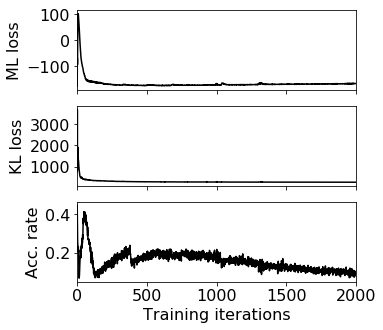

In [55]:
plot_convergence(particle_filter_ex.loss_train, particle_filter_ex.acceptance_rate, figsize=(5, 5));
#plt.savefig(paper_dir + 'figs/particles/explore_conv2.pdf', bbox_inches='tight')

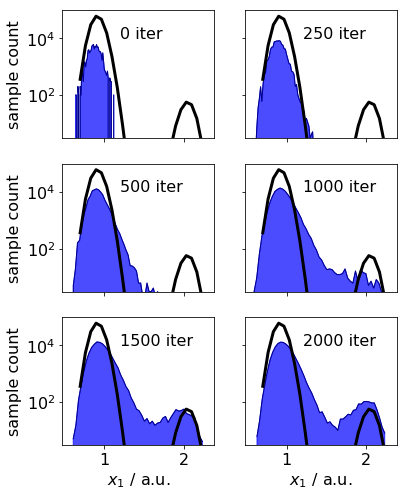

In [56]:
#plot_indices = np.array([0, 1, 2, 5, 10, 19])
plot_indices = np.array([0, 5, 10, 20, 30, 40])
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6,8))

for i, ax in zip(plot_indices, axes.flatten()):
    h, e = np.histogram(Ds[i], bins=50)
    e = 0.5*(e[:-1] + e[1:])
    ax.plot(e, h, color='darkblue', linewidth=1)
    ax.fill_between(e, np.zeros(len(e)), h, color='blue', alpha=0.7)
    ax.text(1.2, 10000, str(i*50)+' iter')
    ax.plot(umbrella_positions, 5*np.exp(-np.mean(umbrella_free_energies, axis=0)), 
            color='black', linewidth=3, label='Eq. dist.')    
    ax.semilogy()
    #plt.legend(ncol=1, fontsize=16, frameon=False)
    ax.set_ylim(3, 100000)
axes[-1, 0].set_xlabel('$x_1$ / a.u.')
axes[-1, 1].set_xlabel('$x_1$ / a.u.')
axes[0, 0].set_ylabel('sample count')
axes[1, 0].set_ylabel('sample count')
axes[2, 0].set_ylabel('sample count')
#plt.savefig(paper_dir + 'figs/particles/explore_conv_hist2.pdf', bbox_inches='tight')